In [66]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import os
from os import walk
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from datetime import datetime,timedelta
import talib as ta
from sklearn.preprocessing import MinMaxScaler
from math import floor
import sys
import pandas as pd

In [67]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [68]:
companies = []
data_path = "/Users/ishan/Coding/Wpi/StockMarketSimulationIQP/Datasets/30y_stock_csvs/"
for (dirpath, dirnames, filenames) in walk(data_path):
    companies.extend(filenames)
    break 

In [77]:
def company(stock,startDate, endDate,startingCapital = (500_000/505),plot = False):
    model = "models/{}-model.json".format(stock)
    if not os.path.isfile("{}/saved_model.pb".format(model)):
        return 0,0,0,0,0
    start = startDate
    days = timedelta(93)
    startDate = startDate - days
    dataPath = "/Users/ishan/Coding/Wpi/StockMarketSimulationIQP/Datasets/30y_stock_csvs"
    dataTrain = pd.read_csv("{}/{}.csv".format(dataPath,stock)) #import csv
    dataTrain['Datetime']= pd.to_datetime(dataTrain['Datetime'])
    if startDate < dataTrain.iloc[0,:]['Datetime']:
        startDate = dataTrain.iloc[0,:]['Datetime']

    dataTrain = dataTrain[~(dataTrain['Datetime'] < startDate)]
    dataTrain = dataTrain[~(dataTrain['Datetime'] > endDate)]
    rsiPeriod = 14
    adxPeriod = 14
    shift = 1
    leftshift = 33
    window = 60

    # %%
    variablesToInclude = ['Close','Volume',"RSI","ADX","fastd","fastk","macd"]
    numberOfFeatures = len(variablesToInclude)
    
    trainingDataPoints = round(len(dataTrain) * .4)
    
    dataTrain.rename(columns = {'CLOSE':'Close'}, inplace = True)
    dataTrain.rename(columns = {'HIGH':'High'}, inplace = True)
    dataTrain.rename(columns = {'LOW':'Low'}, inplace = True)
    dataTrain.rename(columns = {'VOLUME':'Volume'}, inplace = True)


    # %%

    dataTrain['Close'] = dataTrain['Close'].astype(float).fillna(0)
    data = dataTrain['Close']

    dataTrain["RSI"] = ta.RSI(dataTrain['Close'],rsiPeriod).fillna(0)
    dataTrain["ADX"] = ta.ADX(dataTrain['High'],dataTrain['Low'],dataTrain['Close'],adxPeriod).fillna(0)
    fastk, fastd = ta.STOCHF(dataTrain['High'],dataTrain['Low'],dataTrain['Close'])
    dataTrain['fastd'] = fastd
    dataTrain['fastk'] = fastk
    macd, macdsignal, macdhist = ta.MACD(dataTrain['Close'])
    dataTrain['macd'] = macd
    dataTrain['macdsignal'] = macdsignal
    dataTrain['macdhist'] = macdhist
    upper,middle,lower = ta.BBANDS(dataTrain['Close'])
    dataTrain['bb_lowerband'] = lower
    dataTrain['bb_middleband'] = middle
    dataTrain['bb_upperband'] = upper

    # %%
    newTrain = pd.DataFrame()
    newTrain = dataTrain[variablesToInclude]
    newTrain["Close"] = newTrain['Close'].shift(1)

    # %%

    trainingSet = newTrain.iloc[:,0:numberOfFeatures].values #convert to numpy to train RNN
    ySet = data.astype(float).values.reshape(-1, 1)

    # %% [markdown]
    # ## Feature Scaling

    # %%
    # Use normalization x - min(x) / max(min) - min(x)
    sc = MinMaxScaler(feature_range=(0,1)) # all values between 0 and 1
    ySC = MinMaxScaler(feature_range=(0,1))
    ySCSet = ySC.fit_transform(ySet)
    scaleTrainingSet = sc.fit_transform(trainingSet)


    
    regressor=tf.keras.models.load_model(model)
    dataTest = pd.read_csv("{}/{}.csv".format(dataPath,stock)) #import csv
    dataTest.rename(columns = {'CLOSE':'Close'}, inplace = True)
    dataTest.rename(columns = {'HIGH':'High'}, inplace = True)
    dataTest.rename(columns = {'LOW':'Low'}, inplace = True)
    dataTest.rename(columns = {'VOLUME':'Volume'}, inplace = True)

    # %%
    dataTest['Datetime']= pd.to_datetime(dataTest['Datetime'])
    if startDate < dataTrain.iloc[0,:]['Datetime']:
        startDate = dataTrain.iloc[0,:]['Datetime']
    dataTest = dataTest[~(dataTest['Datetime'] < startDate)]
    dataTest = dataTest[~(dataTest['Datetime'] > endDate)]
    dataTest['Close'] = dataTest['Close'].astype(float)
    dataTest["RSI"] = ta.RSI(dataTest['Close'],rsiPeriod)
    dataTest["ADX"] = ta.ADX(dataTest['High'],dataTest['Low'],dataTest['Close'],adxPeriod)
    fastk, fastd = ta.STOCHF(dataTest['High'],dataTest['Low'],dataTest['Close'])
    dataTest['fastd'] = fastd
    dataTest['fastk'] = fastk
    macd, macdsignal, macdhist = ta.MACD(dataTest['Close'])
    dataTest['macd'] = macd
    dataTest['macdsignal'] = macdsignal
    dataTest['macdhist'] = macdhist
    upper,middle,lower = ta.BBANDS(dataTest['Close'])
    dataTest['bb_lowerband'] = lower
    dataTest['bb_middleband'] = middle
    dataTest['bb_upperband'] = upper
    dataTest['Daily Returns'] = dataTest['Close'].pct_change(1)
    
    Sharpe_Ratio = dataTest['Daily Returns'].mean() / dataTest['Daily Returns'].std()
    tradingdays = (endDate-start).days
    sharperatio = (tradingdays ** 0.5) * Sharpe_Ratio
    negs = dataTest[dataTest['Daily Returns']<0]['Daily Returns']
    sortinoRatio = (dataTest['Daily Returns'].mean() / negs.std()) * (tradingdays ** 0.5)

    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = dataTest['Daily Returns'].cummax()
    Daily_Drawdown = (dataTest['Daily Returns']/Roll_Max) - 1.0

    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    calm = dataTest['Daily Returns'].mean()
    calmerRatio = (calm/Max_Daily_Drawdown) * (tradingdays ** 0.5)
    
    # %%
    newTest = pd.DataFrame()
    newTest = dataTest[variablesToInclude]
    
    # %%
    realStockPrice = dataTest['Close'].values #convert to numpy to train RNN
    newTest["Close"] = newTest['Close'].shift(1)
    trainingSet = newTest.iloc[:,0:numberOfFeatures].values #convert to numpy to train RNN
    realStockPrice = realStockPrice[window-shift:]

    # %% [markdown]
    # ## Predict price

    # %%

    inputs = trainingSet
    inputs = sc.transform(inputs)

    # %%
    xTest = []
    for i in range(window+leftshift,len(inputs)):
        xTest.append(inputs[i-window:i])
    xTest = np.array(xTest)
    xTest = np.reshape(xTest, (xTest.shape[0],xTest.shape[1],numberOfFeatures)) #batchsize, inputSize, numberOfFeatures

    # %%
    predictedPrice = regressor.predict(xTest)
    predictedPrice = ySC.inverse_transform(predictedPrice)
    stocksOwned = {}
    startingValue = startingCapital
    liquidValue = startingValue
    dailyReturns = []
    sold = 0

    if plot:
        plt.plot(realStockPrice, color='red', label="Real Stock Price")
        plt.plot(predictedPrice, color='blue', label="Predicted Stock Price")
        plt.title("{} Stock Price".format(stock))
        plt.xlabel('Time')
        plt.ylabel("Price")
        plt.legend()
        plt.savefig('graphs/{}.png'.format(stock))
        plt.figure()


    for i in range(len(predictedPrice)):
        if realStockPrice[i] < predictedPrice[i] and 'GOOGL' not in stocksOwned:
            stocksOwned['GOOGL'] = (realStockPrice[i], liquidValue/realStockPrice[i])
            liquidValue -= liquidValue/realStockPrice[i] * realStockPrice[i]
        elif 'GOOGL' in stocksOwned and stocksOwned['GOOGL'][0] < realStockPrice[i]:
            liquidValue += stocksOwned['GOOGL'][1] * realStockPrice[i]
            percentGain = (realStockPrice[i] - stocksOwned['GOOGL'][0]) / stocksOwned['GOOGL'][0]
            sold += 1
            dailyReturns.append(percentGain)
            stocksOwned.pop('GOOGL')
        if 'GOOGL' in stocksOwned and i == len(predictedPrice) - 1:
            liquidValue += stocksOwned['GOOGL'][1] * realStockPrice[i]
            percentGain = (realStockPrice[i] - stocksOwned['GOOGL'][0]) / stocksOwned['GOOGL'][0]
            dailyReturns.append(percentGain)
            stocksOwned.pop('GOOGL')
            sold += 1
            
    # dailyReturns = pd.Series(dailyReturns,dtype='float')
    # Sharpe_Ratio = dailyReturns.mean() / dailyReturns.std()
    # tradingdays = (endDate-start).days
    # sharperatio = (tradingdays ** 0.5) * Sharpe_Ratio
    # negs = dailyReturns[dailyReturns<0]
    # sortinoRatio = (dailyReturns.mean() / negs.std()) * (tradingdays ** 0.5)

    # # Calculate the max drawdown in the past window days for each day in the series.
    # # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    # Roll_Max = dailyReturns.cummax()
    # Daily_Drawdown = (dailyReturns/Roll_Max) - 1.0

    # # Next we calculate the minimum (negative) daily drawdown in that window.
    # # Again, use min_periods=1 if you want to allow the expanding window
    # Max_Daily_Drawdown = Daily_Drawdown.cummin()
    # calm = dailyReturns.mean()
    # calmerRatio = (calm/Max_Daily_Drawdown) * (tradingdays ** 0.5)
    

    profit = (liquidValue - startingValue)
    return profit,sharperatio,sortinoRatio,calmerRatio,sold


In [70]:
def eval(startDate="1982-3-12", endDate="2022-02-1",weighted = False, companies = companies):
    startDate = datetime.strptime(startDate, "%Y-%m-%d")
    endDate = datetime.strptime(endDate, "%Y-%m-%d")
    startDateThreshold = datetime.strptime("1982-3-12", "%Y-%m-%d")
    spstart = startDate

    if startDateThreshold > startDate:
        spstart = startDateThreshold
    profit = 0

    with HiddenPrints():
        sp500 = yf.download('^GSPC',spstart,endDate)

    profitsp500percentage = ((sp500['Close'][-1] - sp500['Close'][0])/sp500['Close'][0])*100
    profitsp500 = (500_000) * (profitsp500percentage/100)

    profit = 0
    sharperatio = []
    sortinoRatio = []
    calmerRatio = []

    topStock = ""
    maxProfit = float('-inf')
    lowestStock = ""
    minProfit = float('inf')

    index = 1
    sold = 0
    
    for i in companies:
        index += 1
       

        if weighted:    
            weightC = weight[i]
            startingCapital = 500_000 * weightC
            profitC, sharperatioC, sortinoRatioC, calmerRatioC,soldC = company(i, startDate, endDate, startingCapital)

        else:
            i = i[:-4]
            profitC, sharperatioC, sortinoRatioC, calmerRatioC, soldC = company(
                i, startDate, endDate)

        profit += profitC
        sharperatio.append(sharperatioC)
        sortinoRatio.append(sortinoRatioC)
        calmerRatio.append(calmerRatioC)
        sold += soldC
        if profitC < minProfit:
            minProfit = profitC
            lowestStock = i

        if profitC > maxProfit:
            maxProfit = profitC
            topStock = i
        
    sharperatio = pd.Series(sharperatio).dropna()
    sortinoRatio = pd.Series(sortinoRatio).dropna()
    
    profitPercentage = (profit/((500_000/len(weights))*index))*100
    profit = round(profit,2)
    profitPercentage = round(profitPercentage,2)
    profitsp500 = round(profitsp500,2)
    profitsp500percentage = round(profitsp500percentage,2)
    sharperatio = round((sharperatio.mean()),2)
    sortinoRatio = round((sortinoRatio.mean()),2)
    calmerRatio = 0
    minProfit = round(minProfit,2)
    maxProfit = round(maxProfit,2)

    print("Start Date: {}".format(startDate))
    print("End Date: {}".format(endDate))
    print("Profit: ${}".format(profit))
    print("ROI: {}%".format(profitPercentage))
    print("Most Profitable Stock: {}".format(topStock))
    print("Profit for Most Profitable Stock: ${}".format(maxProfit))
    print("Least Profitable Stock: {}".format(lowestStock))
    print("Profit for Least Profitable Stock: ${}".format(minProfit))
    print("Profit S&P500: ${}".format(profitsp500))
    print("S&P500 ROI: {}%".format(profitsp500percentage))
    print("Sharpe Ratio: {}".format(sharperatio))
    print("Sortino Ratio: {}".format(sortinoRatio))
    print("Calmer Ratio: {}".format(calmerRatio))
    print("Traded #{} Times".format(sold))


In [71]:
def normalize(value, sum, length):

    return (value / sum)


def negativeMSE(value, max):
    return (-1 * value)


In [72]:
weights = pd.read_csv("Weights.csv")
weights = weights[weights['MSE'] < 50]

length = len(weights)
maxMSE = weights['MSE'].max()

weights["Neg MSE"] = weights.apply(
    lambda row: negativeMSE(row['MSE'], maxMSE), axis=1)
weights['Transformed MSE'] = MinMaxScaler().fit_transform(
    weights['Neg MSE'].values.reshape(-1, 1))
sums = weights['Transformed MSE'].sum()

weights['Weight'] = weights.apply(lambda row: normalize(
    row['Transformed MSE'], sums, length), axis=1)
weights['Weight'].sum()
companyiesTemp = list(weights['Company'])
companyiesTemp
df = weights[['Company','Weight']]
weight = dict(df.values)

In [83]:
eval(startDate='2021-09-01', endDate='2021-11-1',companies=companyiesTemp, weighted=True)


Start Date: 2021-09-01 00:00:00
End Date: 2021-11-01 00:00:00
Profit: $9432.67
ROI: 1.88%
Most Profitable Stock: AAL
Profit for Most Profitable Stock: $611.43
Least Profitable Stock: MRK
Profit for Least Profitable Stock: $-218.54
Profit S&P500: $8984.13
S&P500 ROI: 1.8%
Sharpe Ratio: -0.06
Sortino Ratio: -0.03
Calmer Ratio: 0
Traded #336 Times


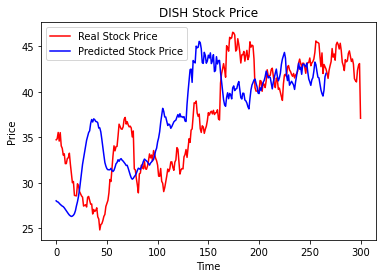

<Figure size 432x288 with 0 Axes>

In [80]:
startDate = datetime.strptime('2020-09-05', "%Y-%m-%d")
endDate = datetime.strptime('2021-11-05', "%Y-%m-%d")
profitC, sharperatioC, sortinoRatioC, calmerRatioC, soldC = company(
    'DISH', startDate=startDate, endDate=endDate, plot=True)


In [81]:
profitC

736.2609583746683